<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS458 Research Assignment 1:


* In this notebook, we will build a `DNN` model for classifying MNIST digits. The `DNN` model will consist of 784 input nodes, a hidden layer with 128 nodes and 10 output nodes (corresponding to the 10 digits).
* We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation.
* After training and evaluating our `DNN` model we analyze its performance. In particular, we use confusion matrices to compare the `predicted classes` with the `class labels` to try to determine why some images were misclassified by the model.
* We then obtain the 60,000 `activation values` of one of the hidden nodes for the (original) set of training data. We want to use these `activation values` as "proxies" for the predicted classes of the 60,000 images.
* And just like we compared the `predicted classes` with the `class labels` using confusion matrices to determine the efficacy of the model, we use `box plots` to visualize the relationship between the `activation values` of one hidden node and the `class labels`. We don't expect these activation values to have much "predictive power". In fact, the same activation values can be associated with multiple class labels resulting in a lot of overlap in the `box plots`.
* We also perform similar experiments comparing the values at two pixel locations in the images with the class labels. This time we use `scatter plots` to visualize the relationship between the pair of pixel values with the class labels (represented by different colored dots).
* Pixel values at two locations in image should not have much predictive value. To improve on this approach, we the PCA decomposition on both the raw data of 784 pixel values and 128 hidden node activation values to reduce the number of features to 2 in each case. Once again, we use a `scatter plot` to visualize the correlation between the two principal component values and the class labels.
*  Finally, we use a Random Forest Classifier to find the relative importance of the 784 features (pixels) in the training set. We then select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.



## Importing Packages

* First we import all the packages that will be used in the assignment.

* Since Keras is integrated in TensorFlow 2.x, we import `keras` from `tensorflow` and use `tenserflow.keras.xxx` to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [71]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as kb

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow version

In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.19.0


In [3]:
import sys
print(sys.version)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


## Research Assignment Reporting Functions

In [4]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

    return mtx

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

## Loading MNIST Dataset

* The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [5]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Sets

* Inspect the training and test sets as well as their labels as follows.

In [6]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


## Review labels for training set

In [7]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



## Find frequency of each label in training and test sets

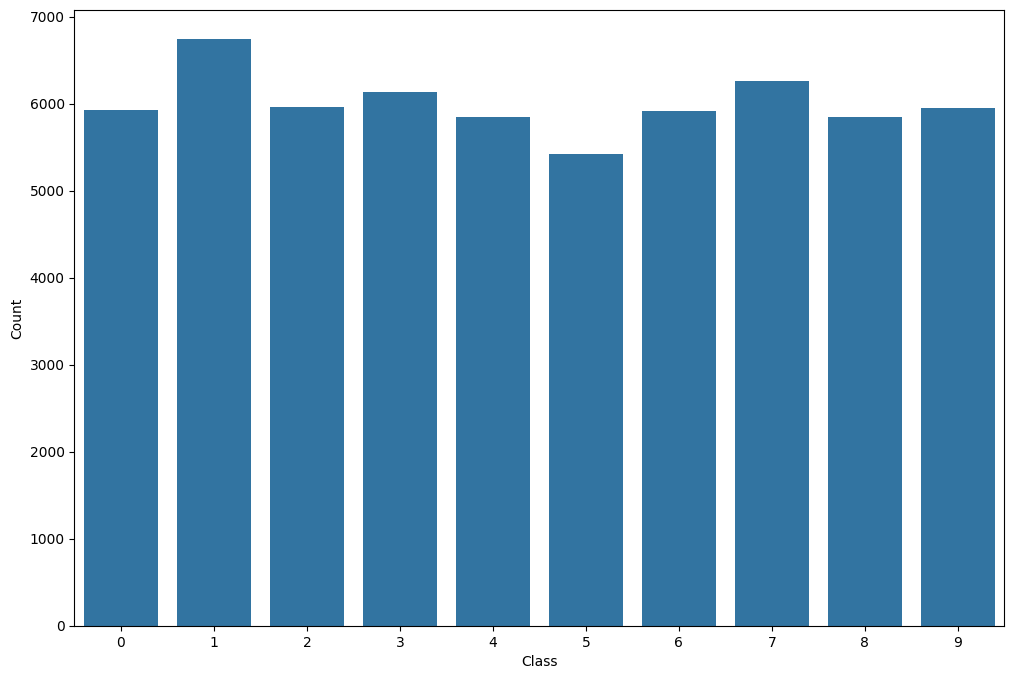

In [8]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

## Plot sample images with their labels

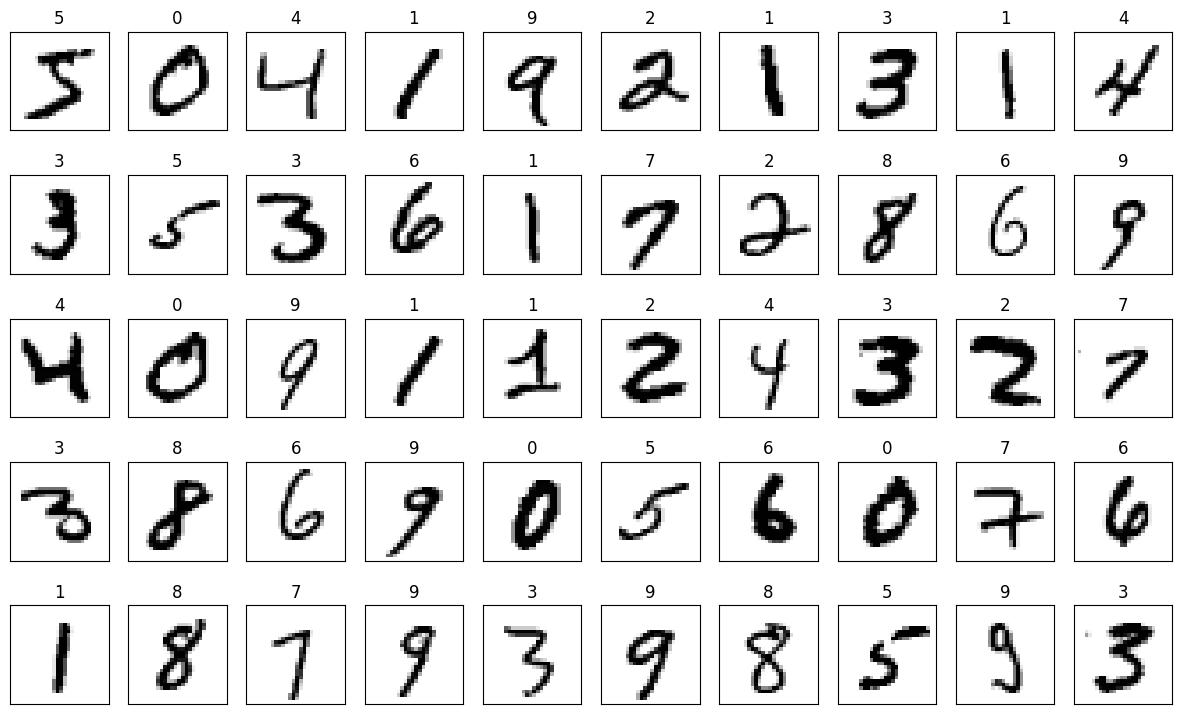

In [11]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

##  Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s.
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

## Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [12]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [15]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))


x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

## Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [17]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

# Experiment 1: Creating the DNN Model

* Our `dense neural network` will consist of 784 input nodes, a hidden layer with `1 node` and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation.
* After training the model, we group the 60,000 `activation values` of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a `boxplot`. We expect the overlap between the range of values in the "boxes" to be minimal.
* In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on CNN models in Assignment 2

## Build the DNN model

* We create a `dense neural network` consisting of `784` input nodes, a hidden layer with `1 node` and `10 output nodes`.

In [97]:
kb.clear_session()
model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


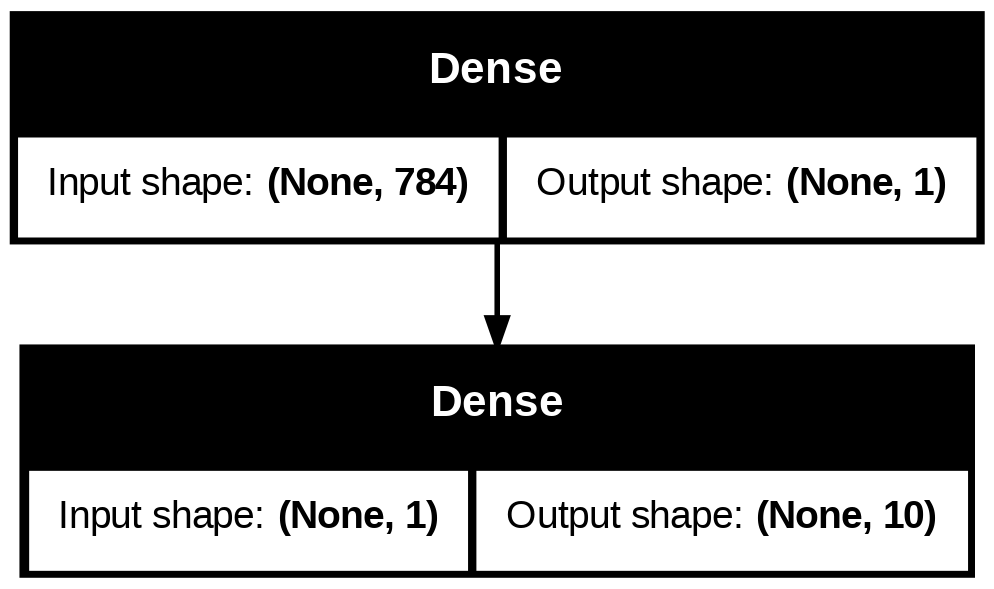

In [39]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True)

## Compile the DNN model

* We will use stochastic gradient descent.

* Regarding loss function, we use categorical cross entropy, which is commonly used in multi-class classification problem.

* Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

In [98]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

## Train the DNN model

In [99]:
history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split = 5000 / 60000
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1886 - loss: 2.0742 - val_accuracy: 0.2646 - val_loss: 1.8274
Epoch 2/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2614 - loss: 1.8137 - val_accuracy: 0.2978 - val_loss: 1.7332
Epoch 3/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2999 - loss: 1.7444 - val_accuracy: 0.3168 - val_loss: 1.6871
Epoch 4/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3093 - loss: 1.7044 - val_accuracy: 0.2902 - val_loss: 1.6578
Epoch 5/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3176 - loss: 1.6860 - val_accuracy: 0.2988 - val_loss: 1.6377


## Evaluate the DNN model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [100]:
model = tf.keras.models.load_model("DNN_model.keras", custom_objects={'softmax_v2': tf.keras.activations.softmax})
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")
# The code above explicitly tells the load_model function to map 'softmax_v2' to the standard softmax activation function.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3232 - loss: 1.7071
Test acc: 0.316


## Plot performance metrics

We use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [49]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [50]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [51]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
2,0.315,1.656,0.324,1.642
3,0.343,1.643,0.354,1.629
4,0.375,1.625,0.381,1.608
5,0.382,1.604,0.380,1.596
6,0.384,1.593,0.376,1.583


In [52]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

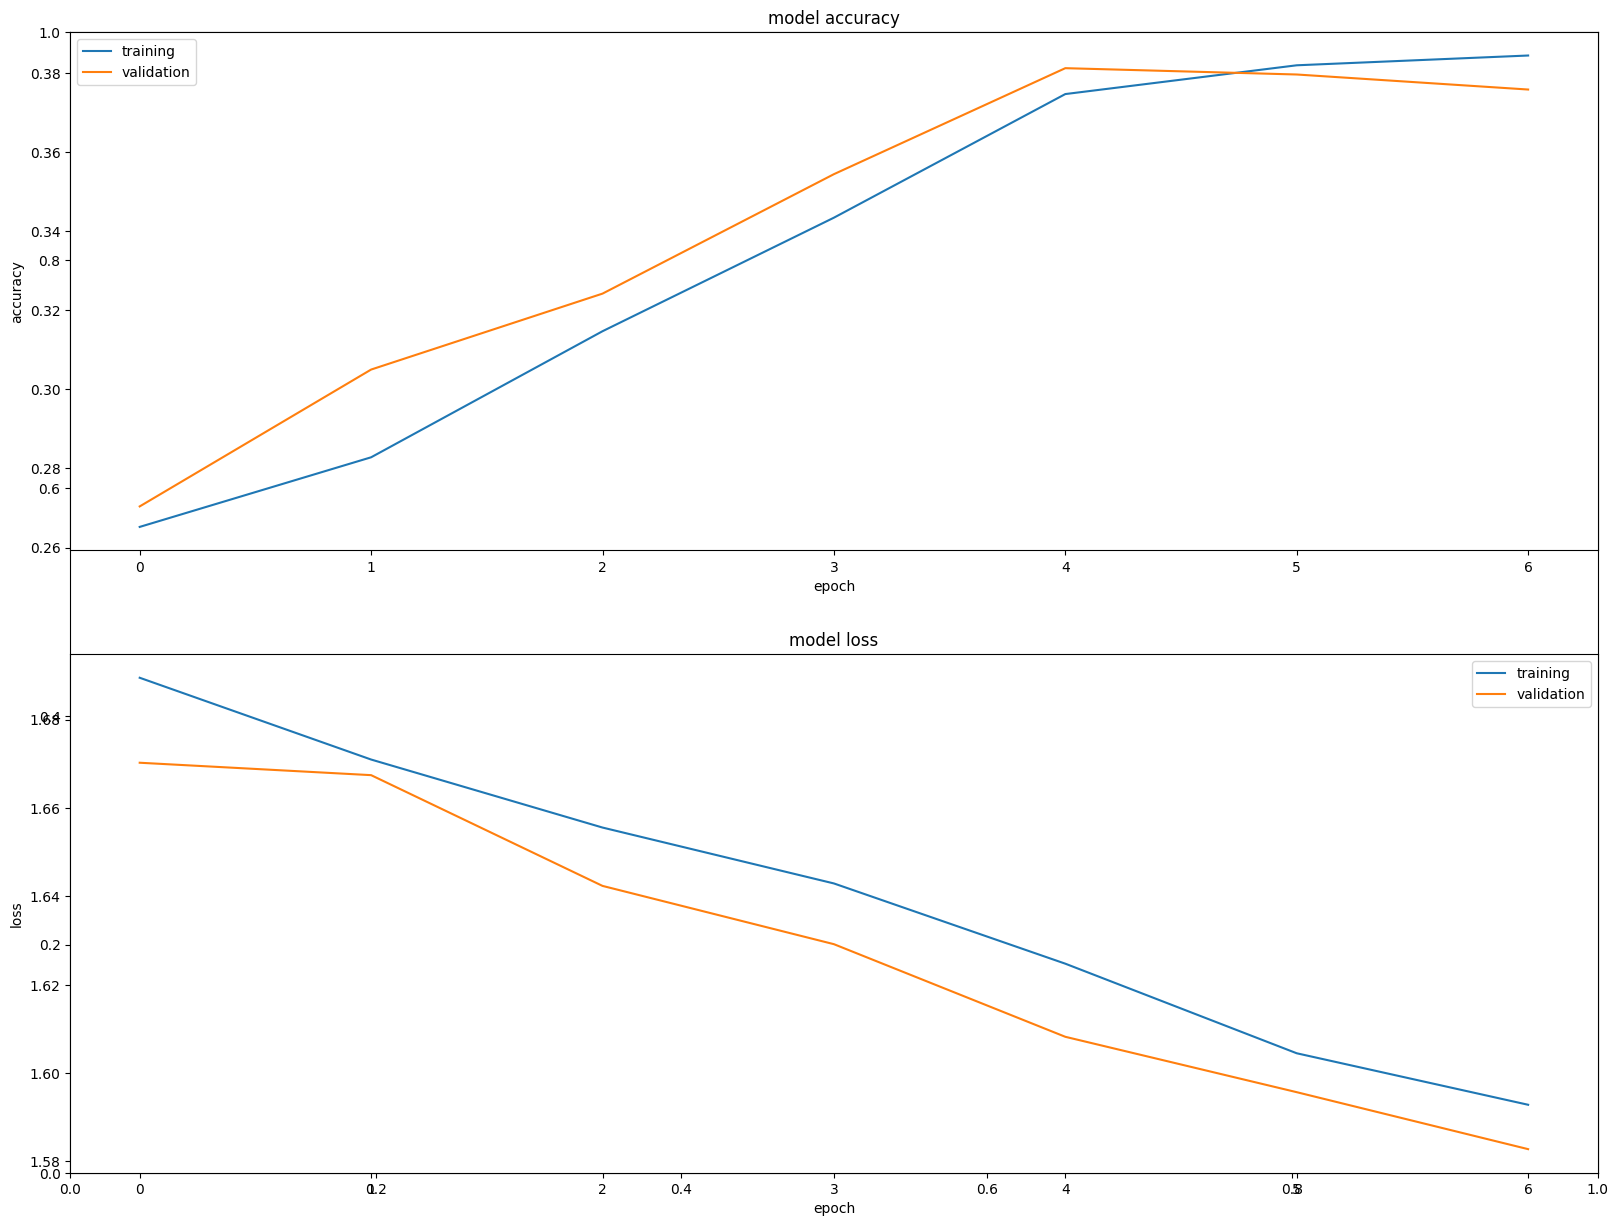

In [53]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)

In [54]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [55]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.30      0.04      0.07       980
           1       0.43      0.83      0.57      1135
           2       0.25      0.06      0.10      1032
           3       0.27      0.40      0.32      1010
           4       0.40      0.47      0.43       982
           5       0.00      0.00      0.00       892
           6       0.34      0.90      0.50       958
           7       0.49      0.72      0.58      1028
           8       0.28      0.04      0.07       974
           9       0.35      0.22      0.27      1009

    accuracy                           0.38     10000
   macro avg       0.31      0.37      0.29     10000
weighted avg       0.32      0.38      0.30     10000

Accuracy Score: 0.3768
Root Mean Square Error: 3.2015152662450324


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualize the confusion matrix
Let's visualize the confusion matrix and see what that tells us.

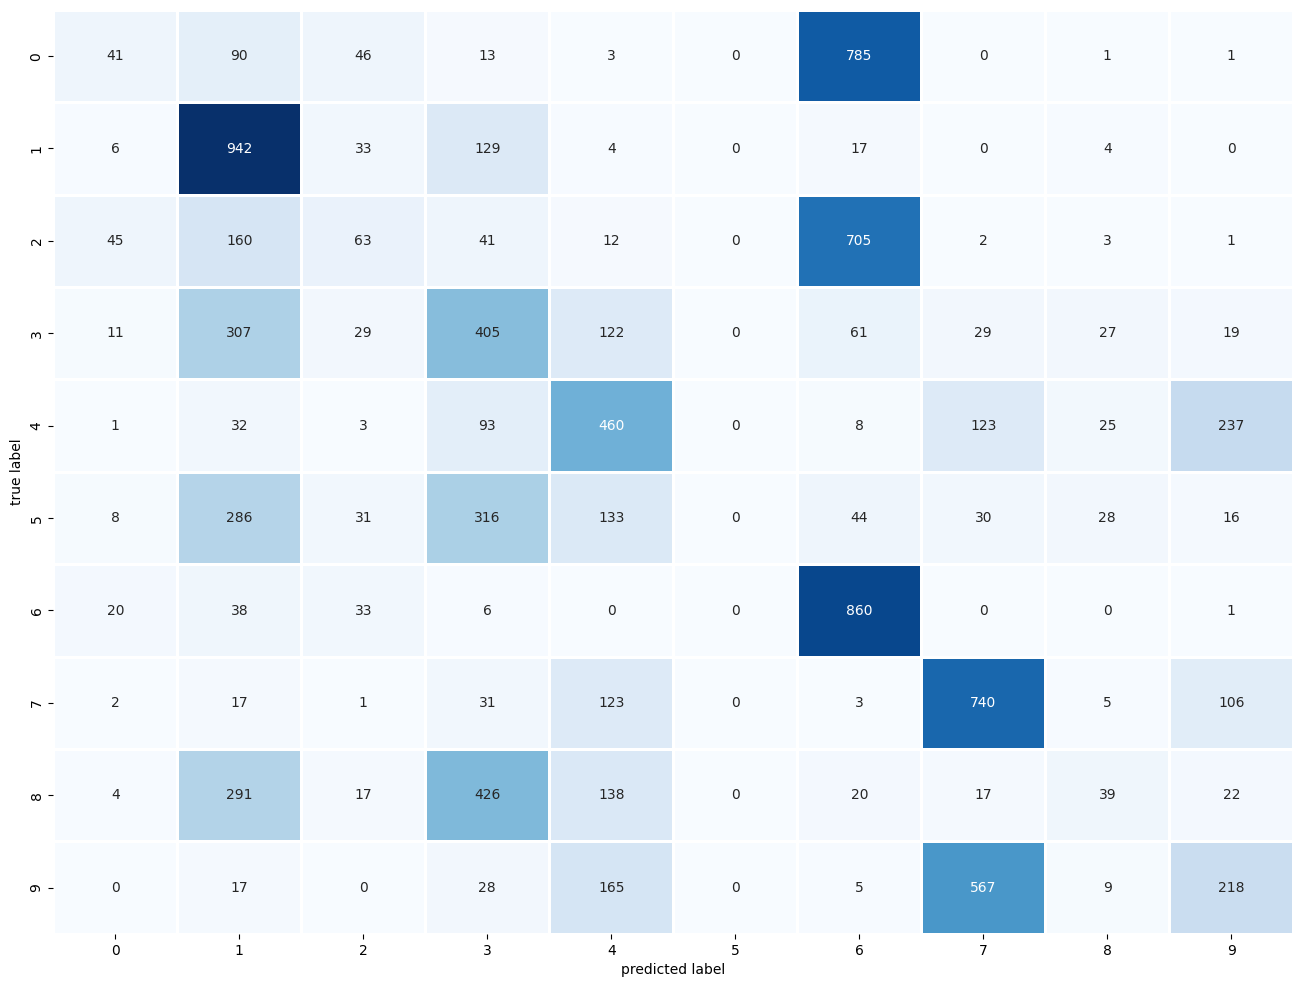

In [59]:
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
mtx = plot_confusion_matrix(y_test,pred_classes)

## Analyzing the Activation Values of the Hidden Nodes

We want to examine the contribution of the individual hidden nodes to the classifications made by the model. We first get the activation values of all the hidden nodes for each of the 60,000 training images and treat these `1 activations` as the features that determine the classification class

Our goal is to use `box plots` to visualize how these activation correlate with the class labels.


 ## Get Activation Values of the Hidden Nodes (1)

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)

# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]

 ## Create a dataframe with the activation values and the class labels

In [66]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}

activation_data[f"act_val_0"] = hidden_layer_activation[:,0]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.000,9.000,2.000,1.000,3.000,1.000,4.000,3.000,5.000,3.000,6.0,1.000
act_val_0,1.109,0.082,3.375,0.968,5.531,0.895,1.297,1.703,1.052,3.251,2.388,1.178,1.084,0.0,0.719


 ## Visualize the activation values with boxplots

We get the activation values of the first hidden node and combine them with the corresponding class labels into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe.

<div class="alert alert-block alert-info">
    <b>seaborn.boxplot</b><br>
   ps://seaborn.pydata.org/generated/seaborn.boxplot.html
    </div>

/tmp/ipython-input-2725227606.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bplot = sns.boxplot(y=act_val, x='actual_class',


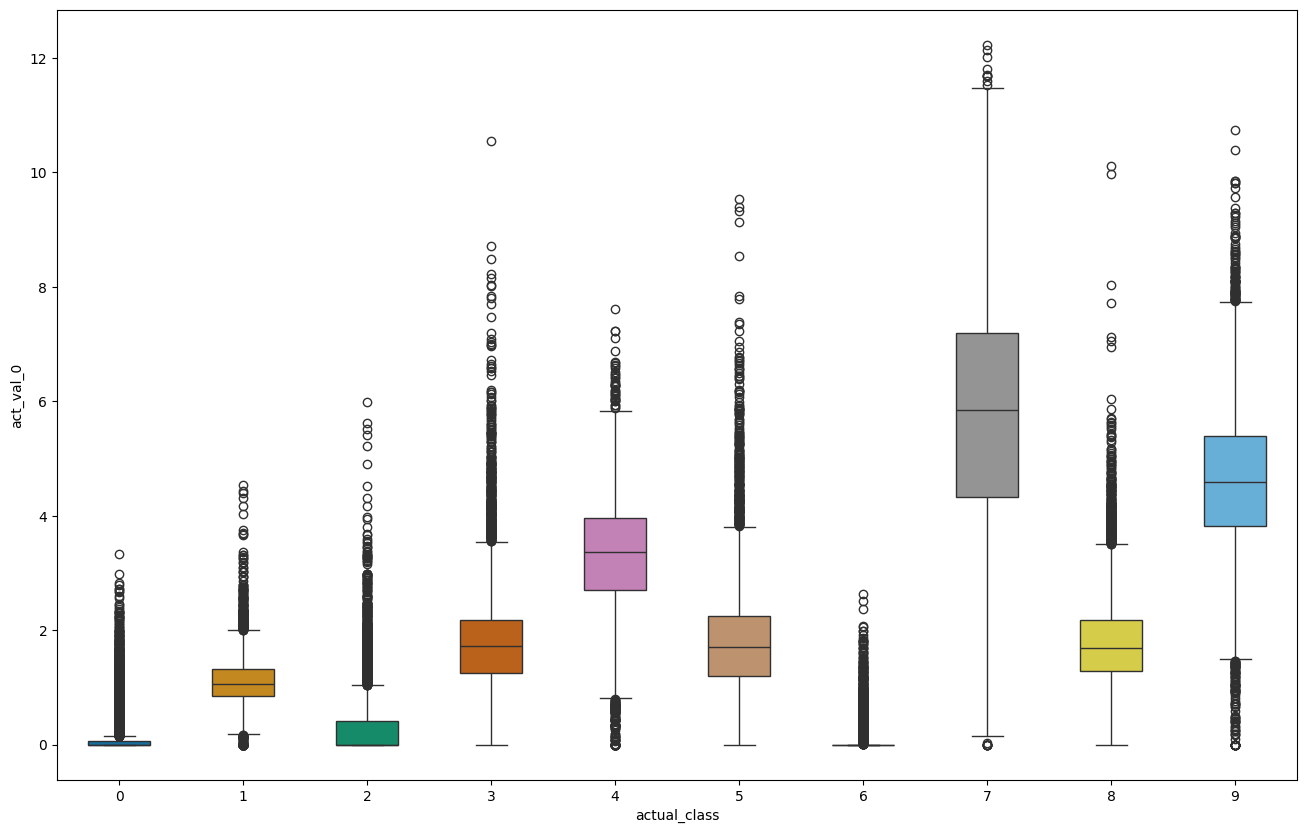

In [67]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
act_val = 'act_val_0'
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y=act_val, x='actual_class',
                 data=activation_df[[act_val,'actual_class']],
                 width=0.5,
                 palette="colorblind")

## Displaying The Range Of Activation Values For Each Class Labels

In [68]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

,actual_class,range_of_act_values
0,0,"[0.0, 3.33]"
1,1,"[0.0, 4.53]"
2,2,"[0.0, 5.99]"
3,3,"[0.0, 10.55]"
4,4,"[0.0, 7.61]"
5,5,"[0.0, 9.52]"
6,6,"[0.0, 2.63]"
7,7,"[0.0, 12.23]"
8,8,"[0.0, 10.11]"
9,9,"[0.0, 10.73]"


# Experiment 2:
* This time our `dense neural network` will have 784 input nodes, a hidden layer with `2 nodes` and `10 output nodes` (corresponding to the 10 digits).
* For each of the 60,000 images, the output of the two hidden nodes are plotted using a scatterplot. We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in `EXPERIMENT 1` the color clusters should have very little overlap.
* Also compare the accuracy % & confusion matrix of Experiments 1 & 2. Again, the goal is to get more insights

## Build, Compile and Train model with 2 hidden nodes.


In [72]:
# Build Model
kb.clear_session()
model = Sequential([
    Dense(input_shape=[784], units=2, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Complie Model
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

#Train Model
history = model.fit(
    x_train_split_norm
    ,y_train_split_encoded
    ,epochs = 200
    ,validation_data=(x_val_norm, y_val_encoded)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3518 - loss: 1.7955 - val_accuracy: 0.5580 - val_loss: 1.3574
Epoch 2/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5606 - loss: 1.3150 - val_accuracy: 0.5848 - val_loss: 1.2453
Epoch 3/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5885 - loss: 1.2218 - val_accuracy: 0.6062 - val_loss: 1.2045
Epoch 4/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6040 - loss: 1.1744 - val_accuracy: 0.6128 - val_loss: 1.1790
Epoch 5/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6159 - loss: 1.1545 - val_accuracy: 0.6214 - val_loss: 1.1604
Epoch 6/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6232 - loss: 1.1379 - val_accuracy: 0.6208 - val_loss: 1.1559
Epoch 7/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6278 - loss: 1.1218 - val_accuracy: 0.6326 - val_loss: 1.1306
Epoch 8/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6388 - loss: 1

## Analyzing the Activation Values of the Hidden Nodes

### Use a scatter plot to visualize the predicive power of the activation values

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


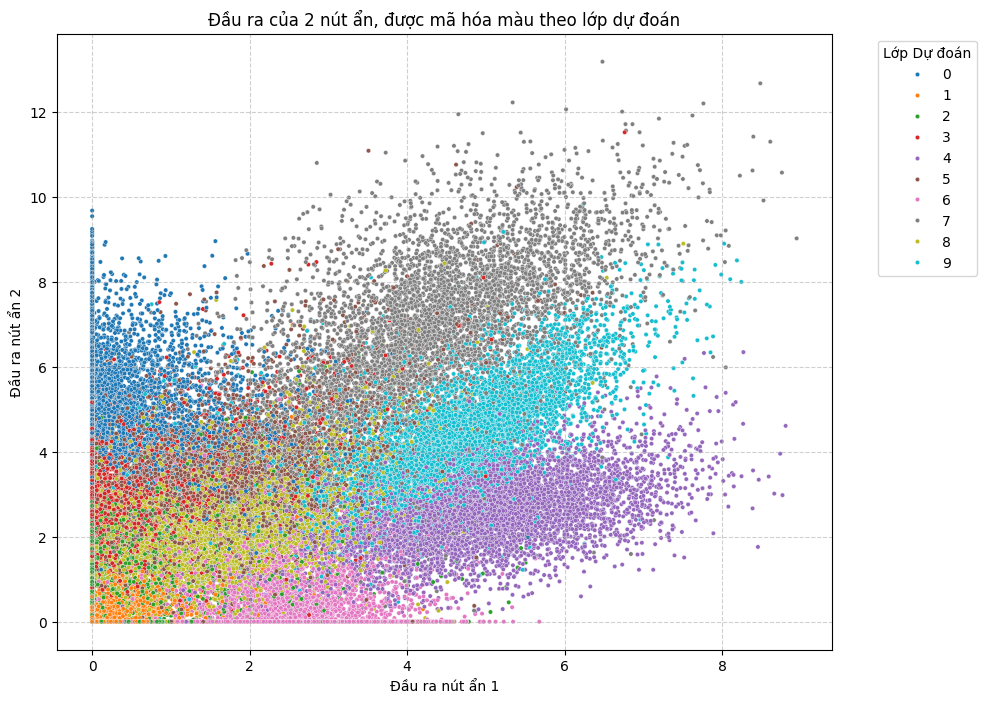

In [74]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)


activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]


plt.figure(figsize=(10, 8))
sns.scatterplot(x=hidden_layer_activation[:, 0], y=hidden_layer_activation[:, 1], hue=y_train, palette='tab10', legend='full', s=10)
plt.xlabel('Activation node 1')
plt.ylabel('Activation node 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Actual class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Compare the accuracy(%) and confusion matrix between experiment 1 and experiment 2


**NEED TO EDIT**


# Experiment 3
Explore with more hidden nodes. Then end up with 1 'final' model. Say the 'best' model.


## Define a model with abitrary hidden node and return the accuracy of that model



In [79]:
def evaluate_with_hidden_nodes(num_hidden_nodes):
  # Build Model
  kb.clear_session()
  model = Sequential([
      Dense(input_shape=[784], units=num_hidden_nodes, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
      Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
  ])

  # Complie Model
  model.compile(optimizer='rmsprop',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

  #Train Model
  history = model.fit(
      x_train_split_norm
      ,y_train_split_encoded
      ,epochs = 200
      ,validation_data=(x_val_norm, y_val_encoded)
      ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras",save_best_only=True,save_weights_only=False)
                  ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
      )
  test_loss, test_acc = model.evaluate(x_test_norm, y_test_encoded)
  return test_acc


You can try some value of number of hidden nodes and take the best one.

In [76]:
candidates = [16, 32, 64, 128, 256, 512]
accuracies = []

for candidate in candidates:
  accuracies.append(evaluate_with_hidden_nodes(candidate))
best_index = accuracies.index(max(accuracies))
best_candidate = candidates[best_index]
best_accuracy = accuracies[best_index]

print('The best candidate is: {} with accuracy: {}'.format(best_candidate, best_accuracy))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8026 - loss: 0.7482 - val_accuracy: 0.9088 - val_loss: 0.3692
Epoch 2/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9173 - loss: 0.3422 - val_accuracy: 0.9180 - val_loss: 0.3366
Epoch 3/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9229 - loss: 0.3153 - val_accuracy: 0.9146 - val_loss: 0.3461
Epoch 4/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9285 - loss: 0.2988 - val_accuracy: 0.9262 - val_loss: 0.3119
Epoch 5/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9343 - loss: 0.2747 - val_accuracy: 0.9294 - val_loss: 0.2920
Epoch 6/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9364 - loss: 0.2699 - val_accuracy: 0.9304 - val_loss: 0.2942
Epoch 7/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9397 - loss: 0.2547 - val_accuracy: 0.9362 - val_loss: 0.2757
Epoch 8/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9406 - loss: 0

In [77]:
df = pd.DataFrame({
    'Hidden Nodes': candidates,
    'Accuracy': accuracies
})
print(df)

   Hidden Nodes  Accuracy
0            16    0.9422
1            32    0.9613
2            64    0.9700
3           128    0.9686
4           256    0.9619
5           512    0.9580


#

# Experiment 4
* Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). We also reduce the number of dimensions of 'best' model from **Experiment 3** to 154 inputs nodes and train it on the new lower dimensional data. We then compare the performance of Experiments 3 and 4.

## Use PCA decomposition
* To reduce the number of dimensions of training set of 28x28 dimansional MNIST imafes from 784 to 154

In [82]:
pca = PCA(n_components=154) # 154 dimentsion
x_train_pca = pca.fit_transform(x_train_norm)
print('Data train after PCA:', x_train_pca.shape)


Data train after PCA: (60000, 154)


## Train on best model in Experiment 3
* In experiment 3, I find `64` hidden nodes work well with MNIST data. So we refine the model with input shape 154 and 64 hidden nodes.

In [94]:
# Data after PCA
x_train_pca = pca.fit_transform(x_train_norm)
x_test_pca = pca.fit_transform(x_test_norm)
# Build Model
kb.clear_session()
model = Sequential([
    Dense(input_shape=[154], units= 64, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Complie Model
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

#Train Model
history = model.fit(
    x_train_pca
    ,y_train_encoded
    ,epochs = 200
    ,validation_split = 5000 / 60000
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )
test_loss, test_acc = model.evaluate(x_test_pca, y_test_encoded)
print('Accuracy: ', test_acc)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'random_state'

## Compare performance between Experiment 3 aand Experiment 4

# Experiment 4
We use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). We train our 'best' dense neural network using these 70 features and compare its performance to the the dense neural network models from EXPERIMENTS 3 and 4.

## Feature selection with Random Forest
We create a Random Forest Classifier (with the default 100 trees) and use it to find the relative importance of the 784 features (pixels) in the training set. We produce a heat map to visual the relative importance of the features. Finally, we select the `70 most important pixels` from the training, validation and test images to test our 'best' model on.

In [86]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_split_norm,y_train_split_encoded)

RandomForestClassifier(random_state=42)

In [90]:
n = 70 # Number of important features
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]

### Plot which pixels are important in images.

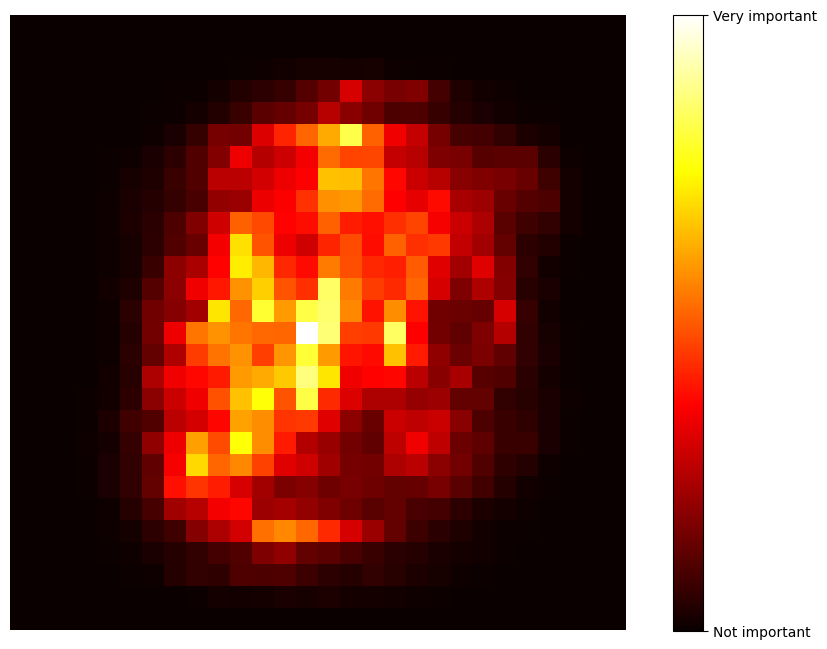

In [87]:
plt.figure(figsize = (12, 8))
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

## Define Model Leveraging 70 Pixels

In [92]:
# 70 Pixels Data
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]

# Build Model
kb.clear_session()
model = Sequential([
    Dense(input_shape=[70], units= 64, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Complie Model
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

#Train Model
history = model.fit(
    train_images_sm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split = 5000 / 60000
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )
test_loss, test_acc = model.evaluate(test_images_sm, y_test_encoded)
print('Accuracy: ', test_acc)

Epoch 1/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7331 - loss: 0.9719 - val_accuracy: 0.8822 - val_loss: 0.4630
Epoch 2/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8665 - loss: 0.5269 - val_accuracy: 0.8986 - val_loss: 0.3969
Epoch 3/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8826 - loss: 0.4612 - val_accuracy: 0.9104 - val_loss: 0.3628
Epoch 4/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8947 - loss: 0.4199 - val_accuracy: 0.9192 - val_loss: 0.3367
Epoch 5/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9036 - loss: 0.3854 - val_accuracy: 0.9274 - val_loss: 0.3161
Epoch 6/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9092 - loss: 0.3676 - val_accuracy: 0.9284 - val_loss: 0.3133
Epoch 7/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9147 - loss: 0.3446 - val_accuracy: 0.9324 - val_loss: 0.2975
Epoch 8/200
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9178 - loss: 0